## Downloading Dataset  
Downloads the Intel Image Classification dataset using `kagglehub`.  


In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/intel-image-classification


## Importing Libraries  
Loads PyTorch, Torchvision, and other necessary libraries for data processing and visualization.  


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

## Data Transformations  
Defines transformations for image preprocessing and augmentation, including resizing, flipping, rotation, and normalization.  


In [3]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize all images to 150x150 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (data augmentation)
    transforms.RandomRotation(10),  # Rotate images randomly by ±10 degrees (data augmentation)
    transforms.ToTensor(),  # Convert images to PyTorch tensors (C, H, W format)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1]
])

## Preparing Datasets and Data Loaders  
Loads the dataset, splits it into training (70%) and validation (30%), and creates data loaders for training, validation, and testing.  


In [4]:
train_dir = os.path.join(dataset_path, "seg_train", "seg_train")
test_dir = os.path.join(dataset_path, "seg_test", "seg_test")

In [5]:
dataset = ImageFolder(root=train_dir, transform=transform)

# Split Dataset into Train (70%) and Validation (30%)
train_size = int(0.7 * len(dataset))  # 70% of the dataset
val_size = len(dataset) - train_size  # Remaining 30% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # Perform the split

In [6]:
# Load Testing Dataset (No Augmentations Applied)
test_dataset = ImageFolder(root=test_dir, transform=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]))

In [7]:
# Create Data Loaders for Training, Validation, and Testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Visualizing Sample Images  
Defines a function to display images and shows six sample images from the training dataset with their class labels.  


In [8]:
# Function to Display an Image
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize image (reverse the normalization effect)
    plt.imshow(img.permute(1, 2, 0))  # Change tensor format to image format
    plt.title(dataset.classes[label])  # Set title as class label
    plt.axis("off")
    plt.show()

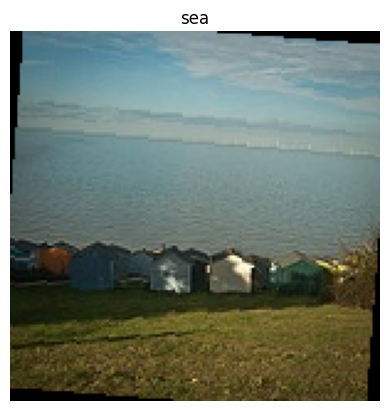

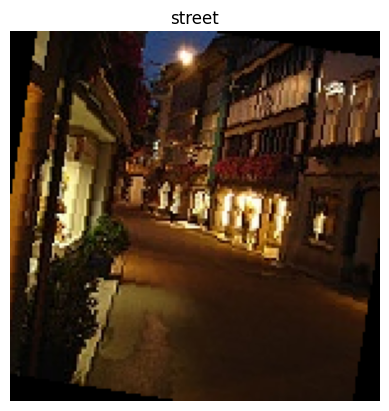

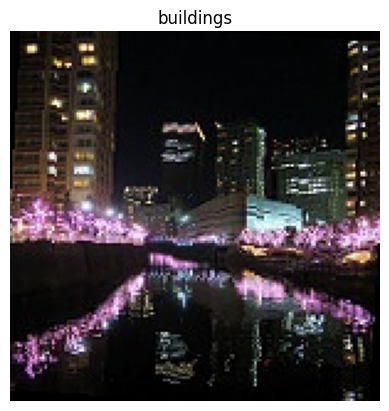

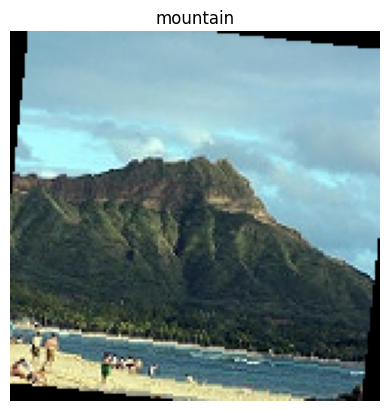

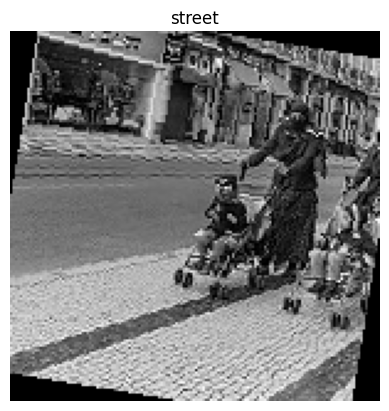

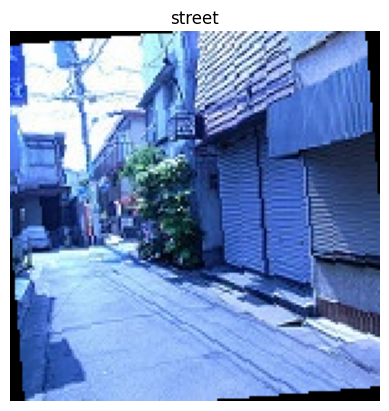

In [9]:
# Get Sample Images from Train Loader and Display 6 Images
images, labels = next(iter(train_loader))  # Get a batch of images
for i in range(6):
    imshow(images[i], labels[i])

## Loading Pretrained Models  
Loads AlexNet and ResNet18 with pretrained weights and modifies the final layer for 6-class classification.  


In [10]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dict = {
    "AlexNet": models.alexnet(pretrained=True),
    "ResNet18": models.resnet18(pretrained=True)
}

# Modify the Classifier for Intel Image Classification (6 Classes)
num_classes = 6
for model_name, model in models_dict.items():
    if model_name == "AlexNet":
        model.classifier[6] = nn.Linear(4096, num_classes)  # Replace final layer
    elif model_name == "ResNet18":
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer
    model = model.to(device)
    models_dict[model_name] = model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 189MB/s]  
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remov

## Training Function with Mixed Precision  
Defines a function to train the model using automatic mixed precision, tracks accuracy and loss, and saves the best model.  


In [ ]:
# Define Training Function with Automatic Mixed Precision
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=32):
    model.to(device)
    best_acc = 0.0  # Track best validation accuracy
    start_time = time.time()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # --- Training Phase ---
        model.train()
        running_loss, correct = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

            # Backpropagation with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)  # Update model parameters
            scaler.update()  # Adjust scaler for next iteration

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Update learning rate
        scheduler.step()

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")

    print(f"Training complete in {(time.time() - start_time) / 60:.2f} minutes")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    return history


## Training Models  
Trains AlexNet and ResNet18 using cross-entropy loss, Adam optimizer, and a learning rate scheduler.  


In [12]:
# Define Hyperparameters and Train Models
history_dict = {
    "AlexNet": None,
    "ResNet18": None
}
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs

    history_dict[model_name] = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=32)


Training AlexNet...

Epoch 1/32
Train Loss: 1.4410, Train Acc: 0.4115
Val Loss: 1.1746, Val Acc: 0.5122

Epoch 2/32
Train Loss: 1.1773, Train Acc: 0.5053
Val Loss: 1.4115, Val Acc: 0.5198

Epoch 3/32
Train Loss: 1.0367, Train Acc: 0.6157
Val Loss: 0.8775, Val Acc: 0.6865

Epoch 4/32
Train Loss: 0.7321, Train Acc: 0.7392
Val Loss: 0.6551, Val Acc: 0.7694

Epoch 5/32
Train Loss: 0.6123, Train Acc: 0.7828
Val Loss: 0.5809, Val Acc: 0.7910

Epoch 6/32
Train Loss: 0.5441, Train Acc: 0.8100
Val Loss: 0.5342, Val Acc: 0.8086

Epoch 7/32
Train Loss: 0.4962, Train Acc: 0.8214
Val Loss: 0.5186, Val Acc: 0.8129

Epoch 8/32
Train Loss: 0.4778, Train Acc: 0.8272
Val Loss: 0.5291, Val Acc: 0.8069

Epoch 9/32
Train Loss: 0.4710, Train Acc: 0.8294
Val Loss: 0.5234, Val Acc: 0.8088

Epoch 10/32
Train Loss: 0.4673, Train Acc: 0.8305
Val Loss: 0.5099, Val Acc: 0.8169

Epoch 11/32
Train Loss: 0.4556, Train Acc: 0.8371
Val Loss: 0.5134, Val Acc: 0.8155

Epoch 12/32
Train Loss: 0.4617, Train Acc: 0.8317
Va

## Model Evaluation Function  
Defines a function to evaluate a trained model on the test set, computing accuracy, F1-score, and the confusion matrix.  


In [13]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Function to evaluate a trained model on the test set
def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())  # Store actual labels
            y_pred.extend(predictions.cpu().numpy())  # Store predicted labels

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy, f1, cm

## Model Evaluation and Confusion Matrix  
Evaluates each trained model on the test set and visualizes the confusion matrix for performance analysis.  



Evaluating AlexNet on test data...
Accuracy: 0.8253
F1-score: 0.8250


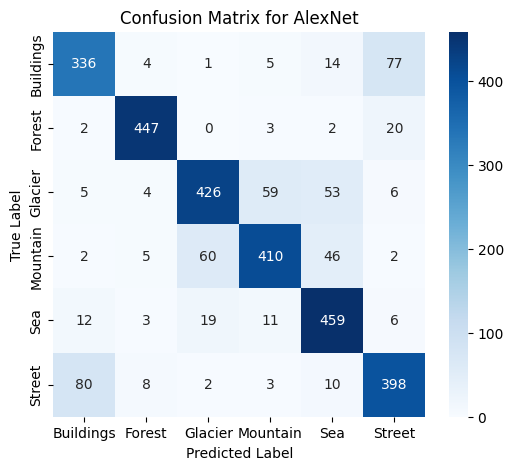


Evaluating ResNet18 on test data...
Accuracy: 0.9303
F1-score: 0.9301


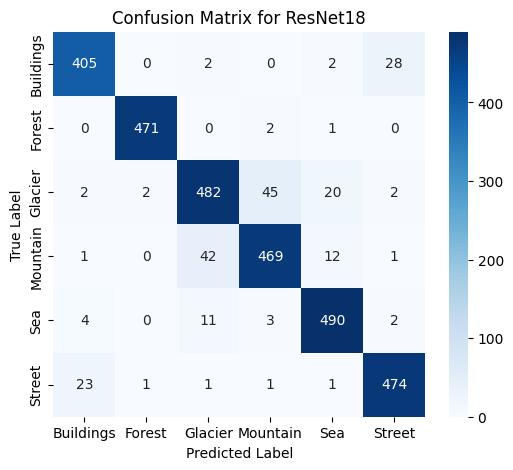

In [14]:
# Evaluate each trained model
for model_name, model in models_dict.items():
    print(f"\nEvaluating {model_name} on test data...")
    accuracy, f1, cm = evaluate_model(model, test_loader)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'], yticklabels=['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

## Training History Plot  
Visualizes the training and validation loss and accuracy curves for each model to analyze performance trends over epochs.  

In [15]:
def plot_training_history(history, model_name):
    epochs = range(1, len(history[model_name]['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    # Loss Plot
    plt.subplot(1,2,1)
    plt.plot(epochs, history[model_name]['train_loss'], label="Train Loss")
    plt.plot(epochs, history[model_name]['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - {model_name}")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1,2,2)
    plt.plot(epochs, history[model_name]['train_acc'], label="Train Accuracy")
    plt.plot(epochs, history[model_name]['val_acc'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curve - {model_name}")
    plt.legend()

    plt.show()

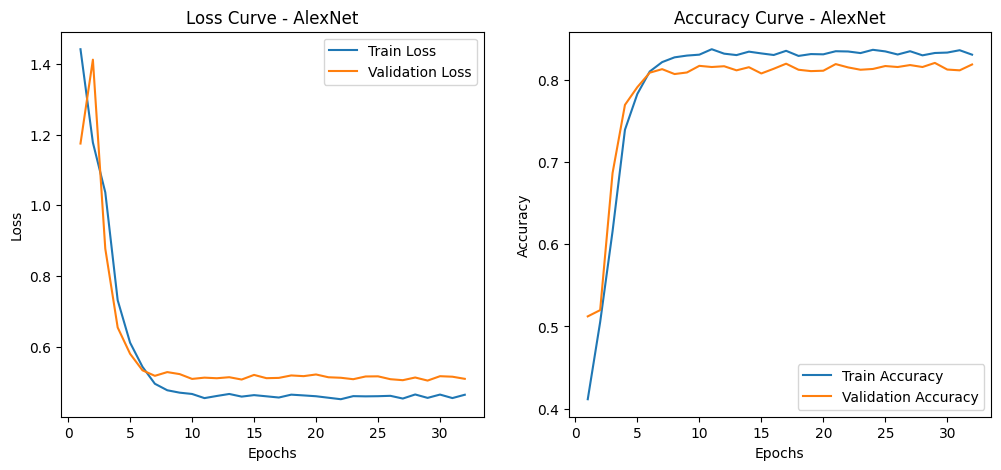

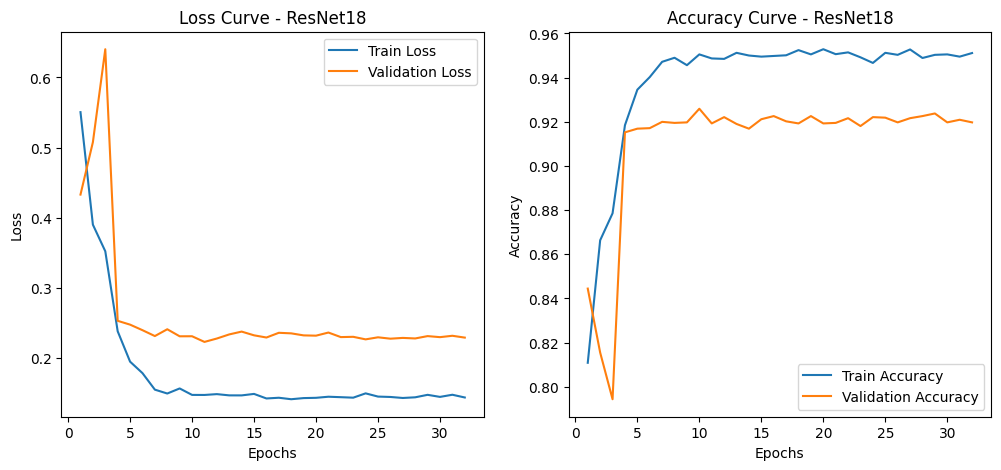

In [16]:
for model_name, model in models_dict.items():
    plot_training_history(history_dict, model_name)

## Load Trained ResNet Model  
Loads the best-trained ResNet model with modified classification layers for inference.  

In [17]:
from PIL import Image
import pandas as pd
model = models.resnet18()
num_classes = 6  # 6 classes: buildings, forest, glacier, mountain, sea, street

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load("best_ResNet.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-17-7b2811f3195b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ResNet.pth", map_location=torch.device("cuda" if torc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Classification on New Data  
Loads images from the prediction dataset, applies the trained model, and saves predictions to a CSV file.  


In [18]:
pred_path = os.path.join(dataset_path, "seg_pred", "seg_pred")

image_files = [f for f in os.listdir(pred_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

predictions = []

for img_file in image_files:
    img_path = os.path.join(pred_path, img_file)

    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        pred_class = output.argmax(dim=1).item()

    predictions.append([img_file, class_names[pred_class]])

    print(f"Image: {img_file} -> Predicted Class: {class_names[pred_class]}")

df_predictions = pd.DataFrame(predictions, columns=["Image", "Predicted Class"])

# Save predictions to CSV
df_predictions.to_csv("predictions.csv", index=False)

print("\n Predictions saved to 'predictions.csv'")


Image: 6234.jpg -> Predicted Class: sea
Image: 22288.jpg -> Predicted Class: street
Image: 20529.jpg -> Predicted Class: mountain
Image: 21440.jpg -> Predicted Class: buildings
Image: 5982.jpg -> Predicted Class: mountain
Image: 7737.jpg -> Predicted Class: buildings
Image: 2081.jpg -> Predicted Class: sea
Image: 10054.jpg -> Predicted Class: glacier
Image: 3919.jpg -> Predicted Class: sea
Image: 21838.jpg -> Predicted Class: forest
Image: 6399.jpg -> Predicted Class: forest
Image: 9960.jpg -> Predicted Class: mountain
Image: 3757.jpg -> Predicted Class: buildings
Image: 9131.jpg -> Predicted Class: buildings
Image: 9062.jpg -> Predicted Class: sea
Image: 4489.jpg -> Predicted Class: glacier
Image: 3417.jpg -> Predicted Class: street
Image: 6074.jpg -> Predicted Class: buildings
Image: 7894.jpg -> Predicted Class: glacier
Image: 10305.jpg -> Predicted Class: buildings
Image: 4407.jpg -> Predicted Class: mountain
Image: 17720.jpg -> Predicted Class: forest
Image: 15979.jpg -> Predicted 